[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YJ_pkujMGHn5UVy6A2qiqyztoDk0o8Ow?usp=sharing)

## Training and Fine-Tuning Vision Transformers

### **1. Install and Import Relevant Libraries**

As always we need to install the relevant modules. We will be utilising datasets provided by Hugging Face. Note, when running the following code in this notebook, some users may be greeted with an error about the `accelerate` module in Python. To fix this, we install transformers like so:

In [1]:
# Stops output in Colab. Remove this if you wish.
%%capture

!pip install datasets
!pip install transformers[torch] accelerate -U

Amazing! We have installed the relevant modules needed to start fine-tuning.

### **2. Load a Dataset**

To perform fine-tuning, we will use a small image classification dataset. We’ll use the `cats_vs_dogs` dataset which is a collection of pictures of cats and dogs. This repository contains custom code so you will have to enter `y` when prompted to do so.

In [2]:
from datasets import load_dataset

ds = load_dataset('cats_vs_dogs')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for cats_vs_dogs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cats_vs_dogs.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Let's take a look at the dataset.

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

Notice how the features in the dataset are `image` and `labels`. This refers to the image data and the labels associated with each image respectively. Moreover, the `num_rows` means that we have 23410 rows of data.

Awesome! Now, let’s look at an example from the `train` split from this dataset. We’ll look at the first entry with index 0.

In [4]:
entry = ds['train'][0]

This returns,

In [5]:
entry

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'labels': 0}

We can clearly see the features of the dataset:

- `image`: A PIL Image
- `labels`: A `datasets.ClassLabel` feature which is given as an integer representation of the label. We may want to translate this into the word (dog or cat) which we’ll do in a moment.

Cool, let’s look at the image!

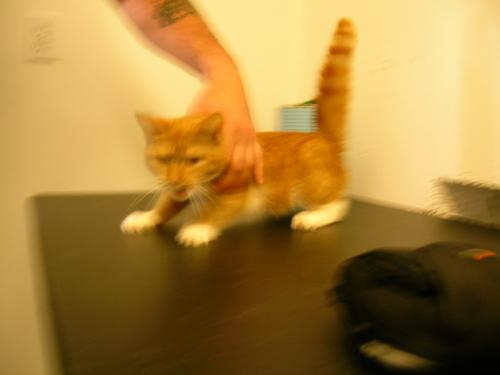

In [6]:
image = entry['image']
image

Despite the image being quite blurry, we can easily detect that this is an image of a cat. When we print out the class label for this image, it should return ‘cat’. Let’s look at how we can do that.

First, we want to access the labels feature of the dataset.

In [7]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['cat', 'dog'], id=None)

So, the names of the class label are indeed ‘cat’ and ‘dog’. Let’s obtain the class label for the image above.

In [8]:
labels.int2str(entry['labels'])

'cat'

Indeed, we get 'cat'!

There are so many images of cats and dogs in this dataset but let’s write a function to see a few more with their corresponding labels.

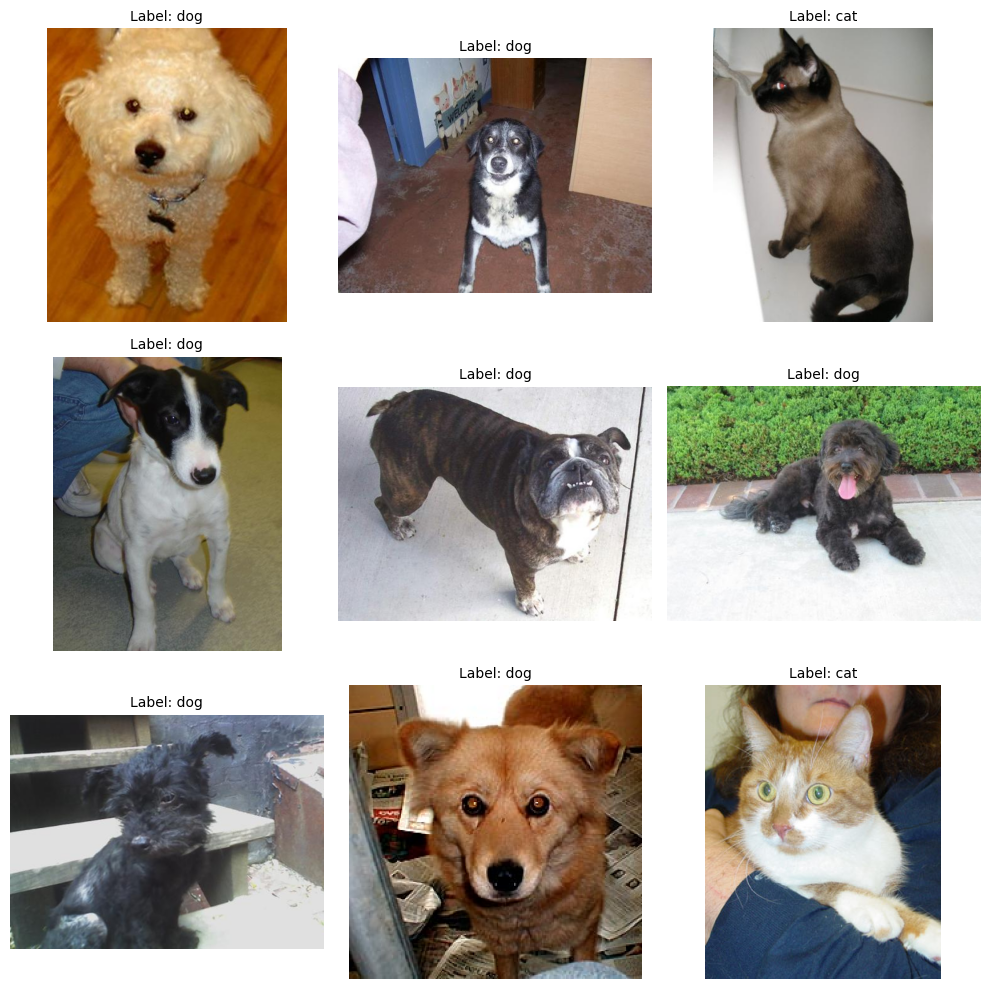

In [9]:
## Display 9x9 grid of dataset
import random
from datasets import load_dataset
import matplotlib.pyplot as plt

# Function to display images with labels in a 3x3 grid
def display_random_images_with_labels(dataset, num_images=9, max_index=23410):
    # Generate random indices
    random_indices = random.sample(range(max_index), num_images)

    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for idx, ax in zip(random_indices, axs.flatten()):
        entry = dataset['train'][idx]
        image = entry['image']
        label_id = entry['labels']
        label_name = dataset['train'].features['labels'].int2str(label_id)

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Label: {label_name}', fontsize=10)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Display 9 random images with their labels in a 3x3 grid
display_random_images_with_labels(ds, num_images=9, max_index=23410)

As expected, we have images of both dogs and cats.

Awesome, so now we've seen what our dataset looks like, it's time to process this data!



### **2. Preparing the Images - ViT Image Processor**

We’ve seen what our images look like in this dataset and so, we are in a good position to begin preparing these for our model!

When vision transformers are trained, it’s important to note that the images that are fed into the model must undergo specific transformations. Using the incorrect transformations results in your model not knowing what it’s looking at!

To ensure we apply the correct transformations, we use `ViTFeautureExtractor`:

In [10]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


This code sets up a feature extractor that can preprocess images to be compatible with the `google/vit-base-patch16-224-in21k` Vision Transformer model.

Let’s take a look at the `feature_extractor`:

In [11]:
# Take a look at the feature extractor
vit_feature_extractor

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

For more information on the entries in this feature extractor, visit our blog that guides you through this notebook!

Now, we can process an image by passing it into this feature extractor.

In [12]:
# Process an image by passing it through the feature extractor
vit_feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.5922,  0.6078,  0.6314,  ...,  0.9137,  0.8902,  0.8745],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8902,  0.8824],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8980,  0.8824],
          ...,
          [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
          [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
          [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

         [[ 0.2863,  0.3020,  0.3255,  ...,  0.5922,  0.5843,  0.5686],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5843,  0.5765],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5922,  0.5765],
          ...,
          [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
          [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
          [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.3176, -0.3020, -0.2784,  ..., -0.0510, -0.0431, -0.0510],
          [-0

This returns a dict containing pixel_values which is the numerical representation that needs to be passed to the model. We specify return_tensors='pt' to ensure we get torch tensors instead of NumPy arrays.

### **4. Processing the Dataset**

We’ve now covered how you can read and transform images into numerical representations. Let’s combine both of these to process a single entry from the dataset.

In [13]:
def process_single_entry(entry):
    processed = vit_feature_extractor(entry['image'], return_tensors='pt')
    processed['labels'] = entry['labels']
    return processed

The `process_single_entry` function takes an entry consisting of an image and its label, preprocesses the image using the ViTFeatureExtractor to convert it into a PyTorch tensor, and then attaches the label to the preprocessed image. The final output is a dictionary containing both the preprocessed image tensor and the label, ready to be used for training or inference with a Vision Transformer model. Let’s look at the first entry as an example:

In [14]:
process_single_entry(ds['train'][0])

{'pixel_values': tensor([[[[ 0.5922,  0.6078,  0.6314,  ...,  0.9137,  0.8902,  0.8745],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8902,  0.8824],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8980,  0.8824],
          ...,
          [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
          [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
          [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

         [[ 0.2863,  0.3020,  0.3255,  ...,  0.5922,  0.5843,  0.5686],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5843,  0.5765],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5922,  0.5765],
          ...,
          [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
          [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
          [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.3176, -0.3020, -0.2784,  ..., -0.0510, -0.0431, -0.0510],
          [-0

Awesome!

We want to do this for every entry in our dataset but this can be slow, especially if you have a large dataset. We can apply a **transform** to the dataset where it is only applied to entries when you index them.

We will be utilising the function `ds.with_transform` which expects a **batch** of data. So, we adjust our `process_single_entry` function to allow for this.

In [15]:
ds = load_dataset('cats_vs_dogs')

# Function to transform the dataset
def transformation(entry_batch):
    transformed = vit_feature_extractor([x for x in entry_batch['image']], return_tensors='pt')
    transformed['labels'] = entry_batch['labels']
    return transformed

This can now be applied to our dataset using `ds.with_transform`. First, we must generate our training and validation datasets.

The `cats_vs_dogs` dataset contains 23410 number of examples. It would be great to fine-tune our existing model on this dataset but for the purpose of the tutorial, we'll create a small subset of this data. Around 1000 training examples and 200 validation examples randomly sampled from the dataset.

Of course, the ideal situation is to have a dataset like [beans](https://huggingface.co/datasets/AI-Lab-Makerere/beans) that is already split into train, validation and test set. However, for the purpose of this tutorial, we wanted to show you how you can fine-tune a standard dataset.

The code below sets up a reproducible way to split a larger dataset into smaller training and validation subsets using Python’s random module to ensure that the selection of indices is consistent across different runs. The DatasetDict from the Hugging Face datasets library is then used to organize these subsets into a manageable format, facilitating easier access and manipulation during the training and validation processes of a machine learning model. This setup is particularly useful for tasks such as training, evaluating, and fine-tuning models where a controlled dataset environment is crucial for benchmarking model performance accurately.

In [16]:
from datasets import DatasetDict
# Set seed for reproducibility
random.seed(42)

# Generate random indices for train and validation datasets
all_indices = list(range(len(ds['train'])))
train_indices = random.sample(all_indices, 1000)
remaining_indices = list(set(all_indices) - set(train_indices))
validation_indices = random.sample(remaining_indices, 200)

# Select the subsets
train_ds = ds['train'].select(train_indices)
validation_ds = ds['train'].select(validation_indices)

# Create a DatasetDict with the new splits
small_ds = DatasetDict({
    'train': train_ds,
    'validation': validation_ds
})

In [17]:
# Apply the transformation
prepared_ds = small_ds.with_transform(transformation)

This means that whenever you get an entry from the dataset, the transform will be applied in real time! Take the first two entries for example:

In [18]:
# Take the first two entries for example
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.7961,  0.7647,  0.7725,  ...,  0.7961,  0.7882,  0.8039],
          [ 0.7490,  0.8039,  0.7647,  ...,  0.8118,  0.8196,  0.8118],
          [ 0.7882,  0.7569,  0.7804,  ...,  0.8118,  0.8196,  0.8196],
          ...,
          [ 0.7098,  0.6941,  0.7098,  ...,  0.7725,  0.7804,  0.7882],
          [ 0.7804,  0.7412,  0.7176,  ...,  0.8353,  0.8588,  0.8667],
          [ 0.8667,  0.7569,  0.7255,  ...,  0.9137,  0.9216,  0.8980]],

         [[ 0.8275,  0.7961,  0.8039,  ...,  0.7725,  0.7647,  0.7804],
          [ 0.7804,  0.8353,  0.7961,  ...,  0.7882,  0.7961,  0.7882],
          [ 0.8196,  0.7882,  0.8118,  ...,  0.7882,  0.7961,  0.7961],
          ...,
          [ 0.7020,  0.6863,  0.7098,  ...,  0.7725,  0.7804,  0.7961],
          [ 0.7725,  0.7333,  0.7098,  ...,  0.8196,  0.8353,  0.8431],
          [ 0.8588,  0.7412,  0.7176,  ...,  0.8902,  0.8902,  0.8588]],

         [[ 0.9137,  0.8824,  0.8902,  ...,  0.7176,  0.7098,  0.7255],
          [ 0

Now the datasets are prepared, let's move onto the training and fine-tuning!


### **5. Training and Fine-Tuning**

We’re ready to train and fine-tune… almost! Our data is processed and we are in a position to use Hugging Face’s `Trainer` feature but in order to use this, we must prepare some things.

**Data Collator:** As we mentioned, we have batches of data which are being inputted as lists of dicts. We need to unpack these.

In [19]:
import torch

# Data collator function
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

The `collate_fn` function is used to collate a batch of examples into a single dictionary that can be used by a PyTorch model. It stacks the image tensors into a single batch tensor and converts the list of labels into a tensor. This function is typically passed to the `DataLoader` to ensure that the data is batched correctly during training or inference.

**Evaluation Metric:** We want to write a function that takes in the models prediction and computes the accuracy.

In [20]:
import numpy as np
from datasets import load_metric

# Metric computation function
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-20-ee229b892449>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The `compute_metrics` function calculates the accuracy of the model's predictions. It does so by:

1. Converting the model's raw prediction scores into predicted class labels using `np.argmax`.
2. Comparing these predicted labels with the true labels (references).
3. Computing the accuracy using the loaded accuracy metric.

This function is used during the evaluation phase of model training to assess how well the model is performing.


**Loading Our Model:** We are now in a position to load our pre-trained model. We will also add `num_labels` to ensure that the model creates a classification head with the right number of units.

In [21]:
from transformers import ViTForImageClassification

# Initialize the model with the correct number of labels
num_labels = len(ds['train'].features['labels'].names)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_labels
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Defining Training Arguments**

We are one step away from fine-tuning! But, first, we must set up the training configuration by defining `TrainingArguments`.

In [23]:
from transformers import TrainingArguments

# Training arguments
training_args = TrainingArguments(
  output_dir="./vit-cat-dogs-demo",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


For a breakdown on what each of these arguments are, head to our article that accompanies this Google Coab notebook.

Let’s Start Training! We utilise Trainer and pass relevant fields:

In [24]:
from transformers import Trainer
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=vit_feature_extractor,
)

Again, for argument explanations, head back to our article.

**Let’s Run the Fine-Tuning!**

All that’s left to do is to run the fine-tuning.

In [25]:
# Train the model
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
10,0.384900,0.126342,0.990000
20,0.091200,0.080837,0.980000
30,0.133600,0.114378,0.970000
40,0.076600,0.120676,0.960000
50,0.136700,0.059736,0.985000
60,0.055900,0.145740,0.950000
70,0.066500,0.101908,0.970000
80,0.021600,0.080557,0.980000
90,0.017100,0.187967,0.945000
100,0.036700,0.124333,0.955000


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 144340078GF
  train_loss               =      0.0857
  train_runtime            =  0:00:54.82
  train_samples_per_second =      36.481
  train_steps_per_second   =       2.298


Awesome! I've attached a screenshot of an example of results outputted when running the script.

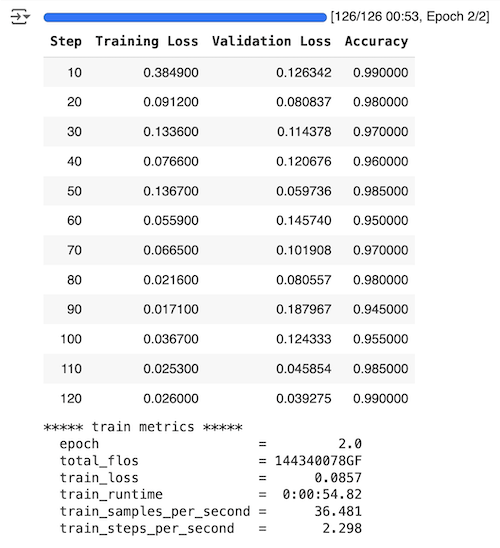

Now, there's a few things we need to talk about here. Let's first discuss the results from the fine-tuning.

These fine-tuning results showcase several important trends and behaviors in the model's learning process over time:

1. **Training Loss**: The training loss generally shows a declining trend as the steps increase, which is an encouraging sign of the model learning and improving from the training data. Notably, the training loss decreases substantially from the initial to the final step, with occasional upticks (such as at steps 30 and 50), which could be due to the model adjusting to complexities or nuances in the dataset.

2. **Validation Loss**: The validation loss shows more variability compared to the training loss. It starts low, increases at certain points (notably at step 90, reaching the peak), and then decreases again. This pattern suggests that the model might be experiencing some challenges in generalizing to unseen data at certain training stages, particularly around step 90.

3. **Accuracy**: The accuracy of the model on validation data starts very high at 99% at step 10 and fluctuates with a general decreasing trend up to step 90, where it drops to its lowest at 94.5%. However, it recovers well towards the end, returning to 99% at step 120. The high starting accuracy could suggest that the model was already quite effective even at early fine-tuning stages, possibly due to pre-training on a similar task or dataset.

4. **Potential Overfitting**: At step 90, where the validation loss is at its highest and accuracy is at its lowest, the model is likely experiencing overfitting. This is indicated by a low training loss coupled with high validation loss and reduced accuracy.

5. **Overall Trends**: The final steps (110 and 120) show an optimal balance with low validation loss and high accuracy, suggesting that the model has achieved a good generalization capability by the end of this fine-tuning phase. This is an encouraging sign that the fine-tuning process has successfully enhanced the model's performance on the validation dataset.



It's important to note that the dataset we choose when fine-tuning is random and so the results you get from running this Google Colab script will not be the same every time.

Looking at the output above, you will notice that the underlying model actually initially performs really well. At step 10, we have an accuracy of 99%! So, fine-tuning for this dataset isn't necessarily needed, depending on what random sample of pictures are generated in the test and validate sets. Of course, if you were to change your dataset to something our base model, `google/vit-base-patch16-224-in21k`, wasn't well suited for then you may see drastic improvements in the fine-tuning process.

We selected this dataset because it's important to be aware of different trends that may happen when fine-tuning:

* **High Variance in Validation Metrics**: If you observe significant fluctuations in validation loss or accuracy, as compared to more stable or consistently improving training metrics, it might indicate that the model is fitting too closely to the training data and not generalizing well to new data.

* **Disparity Between Training and Validation Loss**:
If the training loss continues to decrease while the validation loss starts to increase, it's a classic sign of overfitting. A low training loss accompanied by a high validation loss generally indicates overfitting.

* **Complexity of the Model**: Larger models with more parameters are more prone to overfitting because they have the capacity to learn extremely detailed patterns in the training data. This can be problematic if those detailed patterns do not apply to new data.

* **Insufficient Training Data**: Overfitting is more likely when the model is trained on a small dataset. A model trained on a limited amount of data might not encounter enough variability to generalize well to unseen data.

Why don't you try out different datasets yourself and let us know what results you get in our [Community channel](https://join.slack.com/t/marqo-community/shared_invite/zt-2iab0260n-QJrZLUSOJYUifVxf964Gdw)!